# PROJECT: Course Optimization for Data Science
## Optimization strategies for (Rank-)Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Robert Gower

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs for binary classification with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the "without intercept" case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- use these solvers to tackle the SVM-rank ML problem
- present a clear benchmark of the different strategies on small and medium scale datasets
- test your code on real data!


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 17th of January 2021 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "bastien"
ln1 = "billiot"
fn2 = "simon"
ln2 = "demouchy"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_billiot_bastien_and_demouchy_simon.ipynb


Some imports

In [ ]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`conda install -c conda-forge cvxopt`

(if you're using conda)

or

`pip install cvxopt`

See https://cvxopt.org/install/ for instructions.

If you **struggle too much please contact us**. Don't waste time with this!

<div class="alert alert-info">
    <h2>Part 0: SVM Classification with linear kernel</h2>
</div>

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$
\delta(x_{i},w,b)
$.
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ than all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
       <li>Justify that the problem $(\mathcal{P})$ is convex.</li>
    </ul>
</div>

The problem $(\mathcal{P})$ is convex, if: 
1.   The set $S = \{ (w, b) | y_{i}(w^{T}x_{i}+b)\geq 1, \forall i \in \{1,...,n\}\}$ is convex
2.   the function $g$ defined by $\forall w \in \mathbb{R}^{d}$ and $\forall b \in \mathbb{R}$, $g(w,b) = \frac{1}{2}w^{T}w$ is convex as well \\

However, we have the following elements : 
1.   $\forall i \in \{1,...,n\}$, $y_{i}(w^{T}x_{i}+b) - 1$ is an affine expression, thus the set $S$ is convex
*   The function $g$ defined by $g(w,b) = \frac{1}{2}w^{T}w \quad \forall w \in \mathbb{R}^{d}, \forall b \in \mathbb{R}$ is quadratic and definite symmetric (positive) thus it is convex 

**Conclusion : The problem $(\mathcal{P})$ is convex** \\
***We show a detailed proof below***




To prove that the problem $(\mathcal{P})$ is convex, we will show that the set $S = \{ (w, b) | y_{i}(w^{T}x_{i}+b)\geq 1, \forall i \in \{1,...,n\}\}$ is convex as well as the function $g$ defined by $\forall w \in \mathbb{R}^{d}$ and $\forall b \in \mathbb{R}$, $g(w,b) = \frac{1}{2}w^{T}w$. 

We consider $\lambda \in [0,1]$ and $(s_{1},b_{1}) ,(s_{2},b_{2}) \in S$. 
We have : 
$$ 
(1) : \lambda \times y_{i}(s_{1}^{T}x_{i}+b_{1})\geq \lambda \\
(2) : (1 - \lambda) \times y_{i}(s_{2}^{T}x_{i}+b_{2})\geq (1 - \lambda)
$$

$(1) + (2)$ yields : 

$$ 
y_{i}(\lambda(s_{1}^{T}x_{i}+b_{1}) + (1 - \lambda)(s_{2}^{T}x_{i}+b_{2})) \geq 1 \\
\Longleftrightarrow y_{i}((\lambda s_{1}^{T}+ (1 - \lambda)s_{2}^{T})x_{i}+ (\lambda b_{1} + (1 - \lambda) b_{2}))\geq 1 \\ 
\Longleftrightarrow y_{i}((\lambda s_{1}+ (1 - \lambda)s_{2})^{T} x_{i}+(\lambda b_{1} + (1 - \lambda) b_{2}))\geq 1
$$

Thus, we have  $\forall \lambda \in [0,1]$ and $\forall (s_{1},b_{1}) ,(s_{2},b_{2}) \in S$ : 

$$
(\lambda s_{1}+ (1 - \lambda)s_{2}, \lambda b_{1} + (1 - \lambda) b_{2}) \in S$$
Thus : 
$$ 
\lambda(s_{1},b_{1})+(1 - \lambda)(s_{2},b_{2}) \in  S  
$$
And thus, $S$ is convex. 

\\

We now consider $g$ defined by $\forall w \in \mathbb{R}^{d}$ and $\forall b \in \mathbb{R}$, $g(w,b) = \frac{1}{2}w^{T}w$. \
We have : 
$$
\nabla g(w,b) = \begin{pmatrix}
w \\
0 \\
\end{pmatrix}
$$
And the following Hessian : 
$$
\nabla^{2} g(w,b) = \begin{pmatrix}
I_{d} & 0 \\
0_{d} & 0\\
\end{pmatrix}
$$
With this expression of the Hessian matrix, we can quickly see that it is definite positive on the interior of convex set $S$. Consequently, $g$ is a convex function. 

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
       <li>By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:</li>
    </ul>

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

Remark: We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.
</div>

The Lagrangian associated to the problem $(\mathcal{P})$ is :

$$\mathcal{L}(w, b, \mu) = \frac{1}{2}w^{T}w + \sum_{i = 1}^{n} \mu_i (1 - y_{i}(w^{T}x_{i}+b)) \quad \forall \mu \in  \mathbb{R}_+^n, \quad  \mu = \begin{bmatrix}\mu_{1} \\ \vdots \\ \mu_{n} \end{bmatrix} $$
 
Then we have : $$ \frac{\partial \mathcal{L}(w, b, \mu)}{\partial w} = w - \sum_{i = 1}^{n} \mu_i y_i x_i = w - G^{T} \mu$$
               $$ \frac{\partial \mathcal{L}(w, b, \mu)}{\partial b} = - \sum_{i = 1}^{n} \mu_i y_i = - y^{T}\mu$$
               
Therefore the saddle points verifies : 
 
$$ w^{*} = G^{T} \mu  \quad \text{and} \quad y^{T}\mu = 0$$

Besides, the dual fonction is given by :

$$
\psi :  \left\{
 \begin{array}{cll}
 & \mathbb{R}_+^n \rightarrow \mathbb{R}
 \\
 & \mu \rightarrow  \min_{(w,b)} \frac{1}{2}w^{T}w + \sum_{i = 1}^{n} \mu_i (1 - y_{i}(w^{T}x_{i}+b))
 \end{array}
 \right.
$$

So, we have $\forall \mu \in \mathbb{R}_+^n$ :

$$ 
\psi(\mu) =  \mathcal{L}(w^{*}, b^{*}, \mu) = \frac{1}{2}{w^{*}}^{T}w^{*} + \sum_{i = 1}^{n} \mu_i - \sum_{i = 1}^{n} \mu_i y_{i}{w^{*}}^{T}x_{i} - \sum_{i = 1}^{n} \mu_i y_i b^{*} = \frac{1}{2}{w^{*}}^{T}w^{*} + \mu^{T}u - {w^{*}}^{T}w^{*} - 0 
$$
Consequently, 
$$
\psi(\mu) = \mu^{T}u - \frac{1}{2}w^{T}w = \mu^{T}u - \frac{1}{2}\mu^{T}GG^{T}\mu
$$

Therefore, the dual problem can be written as : 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
       <li>Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:</li>
    </ul>
    $$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$
</div>

As explained in the introduction of this part, in the linear case with intercept, one looks for a learned affine function of $x$ of the form $f : x \in \mathbb{R}^{d} \rightarrow y \in \{-1,1\}$, $f(x) = sign(w^{T}x+b), w \in \mathbb{R}^{d}, b \in \mathbb{R}$. 

Using the saddle point of the Lagrangian of the problem $(\mathcal{P})$ we have : 
$$
w^{*}=G^{T}\mu=\sum \limits^{n}_{i=1} \mu_{i}y_{i}x_{i}
$$
Thus, we have, given the estimated $\mu$, the prediction function for a new sample $x$ is given by : 
$$
y = f(x) = sign({w^{*}}^{T}x+b) = sign((\mu^{T}G)x+b) = sign(\sum \limits^{n}_{i=1} \mu_{i}y_{i}x_{i} ^{T} x +b)
$$

<div class="alert alert-info">
    <h2>Part 1: Implementation of solver with intercept using cvxopt</h2>
</div>

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving svm_project_utils.py to svm_project_utils (4).py


In [ ]:
from svm_project_utils import plot_dataset, datasets

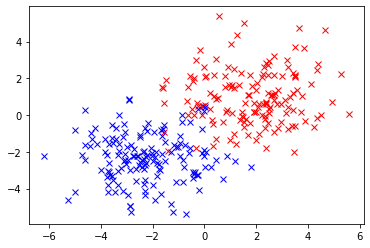

In [ ]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [ ]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(y, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [ ]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
       <li>Modify the following cell to solve the SVM dual problem:</li>
    </ul>
</div>

- The function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

and our dual problem is written as : 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$
Thus we can set the following set : 
$$
 \left\{
 \begin{array}{lll}
 x = \mu 
 \\
 H = GG^{\top}
 \\
 e = u = 1_{n}
 \\
 A = y 
  \\
 b = 0 
 \end{array}
 \right .
 $$

Number of support vectors: 3


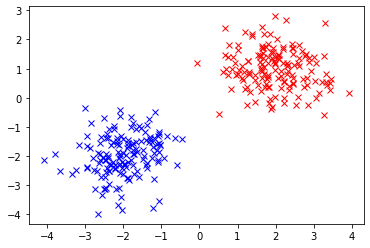

In [ ]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)
plot_dataset(X, y)

# TODO
def g_g_transpose(K, y):
    n = y.shape[0]
    g = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            g[i, j] = y[i] * y[j] * K[i,j]
    return g

def svm_solver(K, y, C=np.inf):
    n = y.shape[0]
    H = g_g_transpose(K, y)
    e = cvxopt.matrix(np.ones(n))
    A = cvxopt.matrix(y)
    b = cvxopt.matrix(0.0)
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)

<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
       <li>Compute w from mu and b</li>
    </ul>
</div>

In [ ]:
# TODO
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)
print(w)

[1.20418452 0.96079746]


<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
       <li>Using complementary slackness, explain how to obtain $b$ from $\mu$.</li>
    </ul>
<br/>
    <b>Remark:</b> complementary slackness states that if $\mu_i$ is an optimal lagrange multiplier and $f_i$ is a constraint of the primal problem than $\mu_i f_i(x^*) = 0$, where x^* is here a primal optimal value (notations here do not match the SVM context).
<br/><br/>
    <b>HINT:</b> Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.
<br/><br/>
    <b>HINT:</b> Have a look at <a href="https://web.stanford.edu/class/ee364a/lectures/duality.pdf">these slides</a> and chapter 5 in <a href="https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf"> this book </a> for more information on convex duality.
</div>

Using the complementary stackness, we have $\mu_{i} f_i(w^*) = 0$ where $f_i$ is a constraint of the primal problem. 
Taking the found optimal value,  $w^{*} = G^{T} \mu = \sum \limits_{i=1}^{n} y_{i}\mu_{i}x_{i}$ and the constraint of the primal problem : $y_{i}(w^{T}x_{i} + b) \geq 1$ we then have : 
$$
\forall i \in \left\{1,...n\right\} \quad \mu_{i}(y_{i}(w^{*T}x_{i} + b) -1) = 0
$$
If we use the fact that for all support vector $i$, $\mu_{i}$ is non-zero then $y_{i}(w^{*T}x_{i}+b) = 1$. 
Then, keeping in mind that $\forall i \in \left\{1,...n\right\}, y_{i} \in \left\{-1 ; 1\right\}$ : 
$$
b = \frac{1}{y_{i}} - w^{*T}x_{i} \quad \mathrm{and}\\
b = y_{i} - \sum \limits^{n}_{j=1} \mu_{j}y_{j}x_{j}^{T}x_{i}
$$
Thus, to find $b$ we only need one support vector $i$ i.e one $i$ such that $\mu_{i}$ is non zero

In [ ]:
# TODO
def compute_b(K, y, mu_support, idx_support):
    # TODO
    y_support = y[idx_support]
    K_support = K[idx_support][:, idx_support]
    # We select the first support vector
    b = y_support[0] - np.sum(mu_support * y_support * K_support[0,:])
    return b

b = compute_b(K, y, mu_support, idx_support)
print(b)

0.9050326459277036


<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
       <li>Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:</li>
    </ul>
$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.
</div>

In [ ]:
# TODO
def check_constraints(X, y, w, b ,epsilon):
    result = np.sum([int(y[i] * (np.dot(w.T, X[i,:]) + b) >= 1 - epsilon) for i in range(y.shape[0])])
    if result == y.shape[0]:
      msg = "All samples meet the primal constraint up to " + str(epsilon) + " precision."
    else:
      msg = "There are " + str(y.shape[0] - result) + " among " + str(y.shape[0]) + " samples that do not meet the primal constraint up to " + str(epsilon) + " precision."
    return result, msg
  
result, msg = check_constraints(X, y, w, b ,1e-5)
print(msg)

All samples meet the primal constraint up to 1e-05 precision.


Check your code by running the following cell:

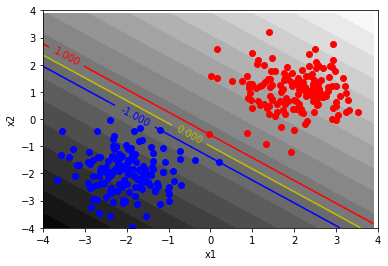

In [ ]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], colors=['b', 'y', 'r'])
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plot_classif(X, y, mu_support, idx_support, b)

We will now change the value of $\sigma$ such that the problem is not linearly separable anymore.

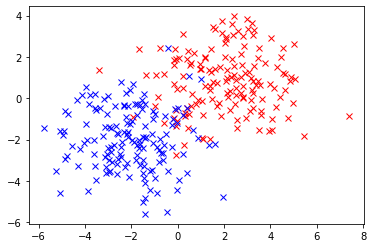

In [ ]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [ ]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
     <ul>
       <li>Check that constraints of the problem are now violated, can you explain what happened? How many are there according to the precision given in Question 7?</li>
    </ul>
</div>

In [ ]:
# TODO
result, msg = check_constraints(X, y, w, b, 1e-5)
print(msg)

There are 283 among 300 samples that do not meet the primal constraint up to 1e-05 precision.


We have changed the value of $\sigma$ of the distribution used to generate the data points such that the problem is not linearly separable anymore. Thus the linear constraint is not met by every point. According to the precision given in Question 7 ($\epsilon = 1e-5$), there are now 283 samples which violate the constraint : 
$$
\forall i,  y_{i}(w^{T}x_{i}+b) \geq 1 - \epsilon
$$

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + c) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
     <ul>
         <li>Justify that $(P_{s})$ is a convex problem.</li>
         <li>Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$
         </li>
    </ul>
</div>

The problem $(\mathcal{P_{s}})$ is convex, if: 
1.   The set $S_{s} = \{ (w, b,\xi) | y_{i}(w^{T}x_{i}+b)\geq 1 - \xi_{i} \quad \textrm{and} \quad -\xi_{i} \leq 0 , \forall i \in \{1,...,n\}\}$ is convex
2.   the function $g$ defined by $\forall w \in \mathbb{R}^{d}$ and $\forall b \in \mathbb{R}$, $g(w,b,\xi) = \frac{1}{2}w^{T}w + C\sum_{i}\xi_{i}$ is convex as well \\

However, we have the following elements : 
1.   $\forall i \in \{1,...,n\}$, $y_{i}(w^{T}x_{i}+b) - 1 + \xi_{i} $ is an affine expression as well as $-\xi_{i}$, thus the set $S_{s}$ is convex
*   The function $g$ defined by $g(w,b) = \frac{1}{2}w^{T}w + C\sum_{i}\xi_{i} $ is quadratic and semi-definite positive thus it is convex.

**Conclusion : The problem $(\mathcal{P})$ is convex** \\
***We show a detailed proof below***



We will use a demonstration similar to the first and second questions. 

To prove that the problem $(\mathcal{P_{s}})$ is convex, we will show that the set $S_{s} = \{ (w, b, \xi) | y_{i}(w^{T}x_{i}+b)\geq 1-\xi_{i}, -\xi_{i} \leq 0, \forall i \in \{1,...,n\}\}$ is convex as well as the function $g$ defined by $\forall w \in \mathbb{R}^{d}$, $\forall b \in \mathbb{R}$ and $\forall \xi$, $g(w,b,\xi) = \frac{1}{2}w^{T}w + C \sum_i \xi_i$. 

We consider $\lambda \in [0,1]$ and $(s_{1},b_{1},\xi_{1}) ,(s_{2},b_{2},\xi_{2}) \in S_{s}$. 
We have $\forall i \in \{1,...,n\}$: 


$$ 
(1) : \lambda \times y_{i}(s_{1}^{T}x_{i}+b_{1})\geq \lambda (1-\xi_{1,i}) \\
(2) : (1 - \lambda) \times y_{i}(s_{2}^{T}x_{i}+b_{2})\geq (1 - \lambda) (1-\xi_{2,i})
$$

$(1) + (2)$ yields : 

$$ 
y_{i}(\lambda(s_{1}^{T}x_{i}+b_{1}) + (1 - \lambda)(s_{2}^{T}x_{i}+b_{2})) \geq \lambda (1-\xi_{1,i}) + (1 - \lambda) (1-\xi_{2,i}) \\
\Longleftrightarrow y_{i}((\lambda s_{1}^{T}+ (1 - \lambda)s_{2}^{T})x_{i}+ (\lambda b_{1} + (1 - \lambda) b_{2}))\geq \lambda + (1 - \lambda) - \lambda \xi_{1,i} - (1 - \lambda) \xi_{2,i}\\ 
\Longleftrightarrow y_{i}((\lambda s_{1}+ (1 - \lambda)s_{2})^{T} x_{i}+(\lambda b_{1} + (1 - \lambda) b_{2}))\geq 1 - ( \lambda \xi_{1,i} + (1 - \lambda) \xi_{2,i})
$$

Thus given that $\lambda \in [0,1]$ and $\xi_{1,i} \geq 0$, $\xi_{2,i} \geq 0$,  $- ( \lambda \xi_{1,i} + (1 - \lambda) \xi_{2,i}) \leq 0 $

Thus, we have  $\forall \lambda \in [0,1]$ and $\forall (s_{1},b_{1},\xi_{1}) ,(s_{2},b_{2},\xi_{2}) \in S_{s}$ : 

$$
(\lambda s_{1}+ (1 - \lambda)s_{2}, \lambda b_{1} + (1 - \lambda) b_{2}, \lambda \xi_{1} + (1 - \lambda) \xi_{2}) \in S_{s}$$
Thus : 
$$ 
\lambda(s_{1},b_{1},\xi_{1})+(1 - \lambda)(s_{2},b_{2},\xi_{2}) \in  S_{s}  
$$
And thus, $S_{s}$ is convex. 

\\

We now consider $g$ defined by $\forall w \in \mathbb{R}^{d}$, $\forall b \in \mathbb{R}$ and $\forall \xi$, $g(w,b,\xi) = \frac{1}{2}w^{T}w + C \sum_i \xi_i$.  \
We have : 
$$
\nabla g(w,b,\xi) = \begin{pmatrix}
w \\
0 \\
C \\
. \\
.\\
. \\
C
\end{pmatrix}
$$
And the following Hessian : 
$$
\nabla^{2} g(w,b,\xi) = \begin{pmatrix}
I_{n} & 0 & 0_{n} \\
0_{n} & 0 & 0_{n}\\
0_{n} & 0 & 0_{n}
\end{pmatrix}
$$
With this expression of the Hessian matrix, we can quickly see that it is positive-definite on the interior of convex set $S_{s}$. Consequently, $g$ is a convex function. 

**To sum up, the problem $(\mathcal{P_{s}})$ is convex.**

The Lagrangian which is associated with the problem $\mathcal(P_{s})$ can be written : 
$$
L(w,b,\xi,\mu, \lambda) = \frac{1}{2} w^{T}w + C \sum_{i} \xi_{i} + \sum_{i} \mu_{i} (1 - \xi_{i} - y_{i}(w^{T}x_{i} +b)) - \sum_{i} \lambda_{i}\xi_{i}
$$
Thererefore, 
$$
\frac{\partial L(w,b,\xi,\mu, \lambda)}{\partial w} = 0 \Leftrightarrow w - \sum_{i} \mu_{i}y_{i}x_{i} = 0 \Leftrightarrow w^{*} = \sum_{i} \mu_{i}y_{i}x_{i} \Leftrightarrow w = G^{T}\mu
$$
$$
\frac{\partial L(w,b,\xi,\mu, \lambda)}{\partial b} = 0 \Leftrightarrow \sum_{i} \mu_{i}y_{i} = 0 \Leftrightarrow y^{T}\mu= 0
$$
$$
\frac{\partial L(w,b,\xi,\mu, \lambda)}{\partial \xi_{i}} = 0 \Leftrightarrow C - \mu_{i} - \lambda_{i} = 0 \Leftrightarrow C = \mu_{i} + \lambda_{i}
$$
We therefore have : 
$$ 
L(w,b,\xi,\mu, \lambda) = \frac{1}{2} w^{T}w + \sum_{i} \mu_{i} - \sum_{i} \mu_{i}y_{i}w^{T}x_{i} - \sum_{i} \mu_{i}y_{i}b
$$
We have : $w = \sum_{i} \mu_{i}y_{i}x_{i}$ and $\sum_{i} \mu_{i}y_{i} = 0$ \
Therefore, 
$$ 
L(w,b,\xi,\mu, \lambda) = \frac{1}{2} w^{T}w + \sum_{i} \mu_{i} - w^{T}w = \sum_{i} \mu_{i} - \frac{1}{2} w^{T}w
$$
Lastly we get : 
$$
L(w,b,\xi,\mu, \lambda) = - \frac{1}{2} \mu^{T}GG^{T}\mu + \mu^{T}u
$$
with $u = (1,1,...1,)$ : 
$$
y^{T}\mu= 0 \\
C = \mu_{i} + \lambda_{i} \Leftrightarrow C - \lambda = \mu \Leftrightarrow \mu \leq C
$$
since $\lambda \geq 0$ \\
Therefore the problem $\mathcal(P_{s})$ can be brought to the dual problem $\mathcal(D)$
$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$


<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
       <li>Modify your code from Question 4 to handle the non-separable case.</li>
    </ul>
</div>

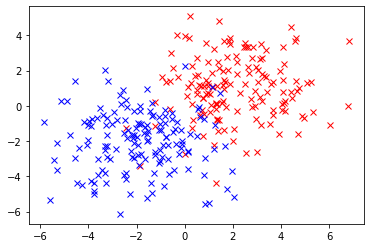

In [ ]:
#TODO
X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
plot_dataset(X,y)

In [ ]:
K = kernel(X, X)
def compute_b_ns(K, y, mu_support, idx_support, C): 
  mu = np.zeros(K.shape[0])
  mu[idx_support] = mu_support 
  ind = idx_support[np.where((C - mu_support)> 1e-5)[0][0]]
  b = y[ind] - np.sum((y[idx_support] * mu_support) * K[ind, idx_support], axis=0)
  return b 

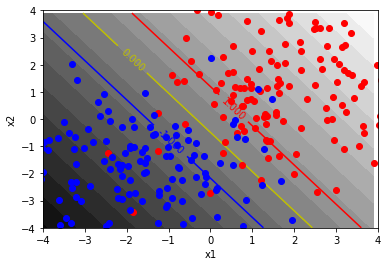

In [ ]:
mu_support, idx_support = svm_solver(K, y , C = 1)
b = compute_b_ns(K, y,  mu_support, idx_support, C=1)
plot_classif(X, y, mu_support, idx_support, b)

<div class="alert alert-success">
    <b>QUESTION 11:</b>
     <ul>
       <li>What is the influence of C on the number of support vectors? Make a plot that demonstrates this empirically.</li>
    </ul>
</div>

--------------------------------------------------------
C = 0.00100
Number of support vectors: 202


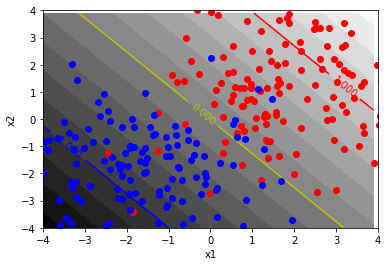

--------------------------------------------------------
C = 0.01000
Number of support vectors: 103


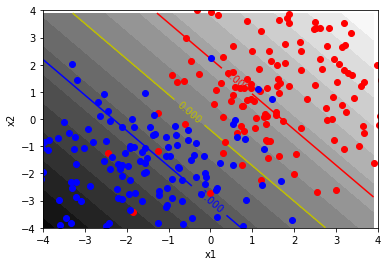

--------------------------------------------------------
C = 0.10000
Number of support vectors: 61


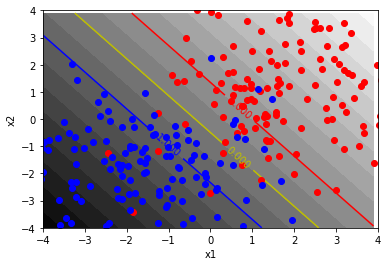

--------------------------------------------------------
C = 1.00000
Number of support vectors: 53


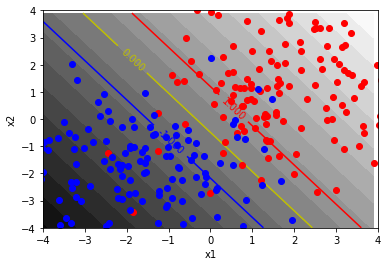

--------------------------------------------------------
C = 10.00000
Number of support vectors: 52


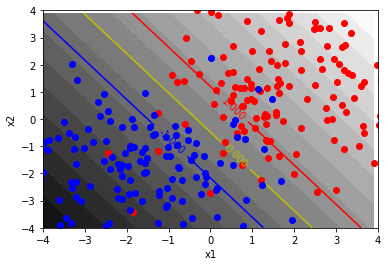

--------------------------------------------------------
C = 100.00000
Number of support vectors: 53


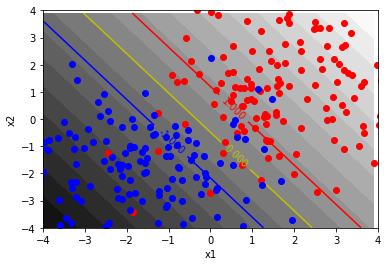

--------------------------------------------------------
C = 1000.00000
Number of support vectors: 59


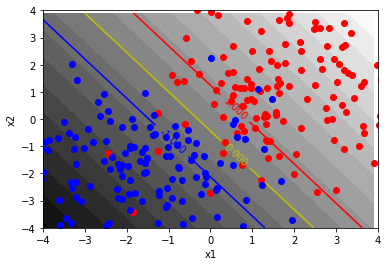

--------------------------------------------------------
C = 10000.00000
Number of support vectors: 123


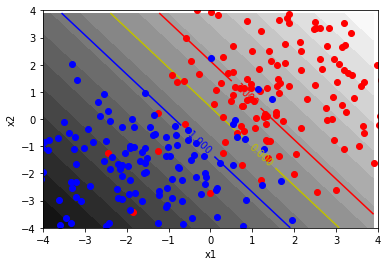

In [ ]:
num_sup_vec = []
C_test = [10**i for i in range(-3,5)]
for C in C_test:
  print("--------------------------------------------------------")
  print("C = %.5f" %C)
  mu_support, idx_support = svm_solver(K, y , C)
  print("Number of support vectors: %s" % idx_support.size)
  num_sup_vec.append(idx_support.size)
  b = compute_b_ns(K, y,  mu_support, idx_support, C)
  plot_classif(X, y, mu_support, idx_support, b)
  plt.show()

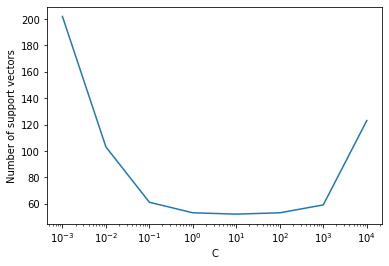

In [ ]:
plt.xscale('log')
plt.plot(C_test, num_sup_vec)
plt.xlabel('C')
plt.ylabel('Number of support vectors')
plt.show()

*   We notice that if C is too small or too high, the number of support vectors explodes. On the contrary, for a well-controlled value of C, the number of support vector is smaller
*   We also notive that if C is small, the allowed margin is very large. Indeed, a small value of C reduced missclassification penalization. Thus, as a support vector is either close to the margin or outside the margin, a large margin results in a high number of vector support. Thus if C is very small we have many support vectors. 
*   We see that C has to exceed $10^{2}$ for the number of support vectors to go up again.

<div class="alert alert-info">
    <h2>Part 3: non-linear case with kernels</h2>
</div>

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

<div class="alert alert-success">
    <b>QUESTION 12:</b>
     <ul>
       <li>Denoting by $K(x_i, x_j)$ the dot product between samples, show that dual problem and the decision function f(x) can be reformulated just using calls to $K$</li>
    </ul>
</div> 

In the dual problem, the decision function $f(\mu)$ is equal to : $\frac{1}{2}\mu^{\top}GG^{t}\mu - \mu^{\top}u$. We can re-write this quantity such that :

$$ f(\mu) = \frac{1}{2} \sum_{i=1}^{n} y_i y_j \mu_i \mu_j x_{i}^{\top} x_{j} -  \mu^{\top}u = \frac{1}{2} \sum_{i=1}^{n} y_i y_j \mu_i \mu_j K(x_{i},x_{j}) -  \mu^{\top}u$$

and the  the dual problem becomes
$$
\begin{cases}
\min_{\mu} \frac{1}{2} \sum_{i,j} \mu_i \mu_j y_i y_j K(x_i,x_j) - \mu ^\top u \\
y^\top \mu = 0\\
0 \leq \mu \leq C \\
\end{cases}
$$
Moreover, the decision functiun can also be reformulated as : 
$$ 
 f(x) = sign(\sum_{i=1}^{n} \mu_{i}y_{i} x_{i}^{T}x + b) = sign(\sum_{i=1}^{n} \mu_i y_i K(x_i,x) + b)
$$

We will use the clowns dataset to evaluate this:

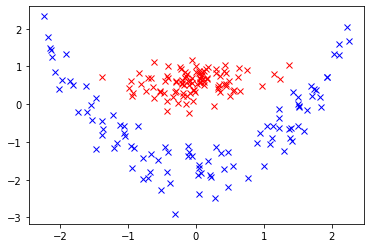

In [ ]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

plot_dataset(X, y)

<div class="alert alert-success">
    <b>QUESTION 13:</b>
     <ul>
       <li>Update your kernel function so it computes the Gaussian kernel:</li>
    </ul>
    $$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|^2)
$$

where $\gamma > 0$ is the kernel bandwidth.
</div> 

In [ ]:
# TODO

from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = 3.
    # TO DO
    for i in range(n1):
        for j in range(n2):
            norm = np.linalg.norm(X1[i] - X2[j], ord=2) ** 2
            K[i, j] = np.exp(-gamma * norm)
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

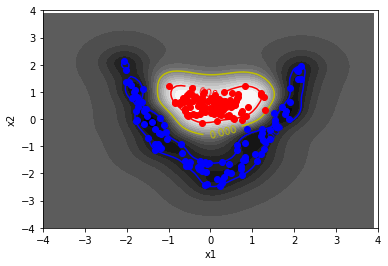

In [ ]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=1.)
b = compute_b_ns(K, y, mu_support, idx_support, C=1.)


plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

<div class="alert alert-info">
    <h2>Part 4: Linear SVM without intercept</h2>
</div>

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^\top \mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

<div class="alert alert-success">
    <b>QUESTION 14:</b>
     <ul>
       <li>Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$
         </li>
    </ul>
</div> 

The Lagrangian associated to the problem $(\mathcal{P_{s}^{'}})$ is :

$$\mathcal{L}(w,\xi, \mu, \lambda) = \frac{1}{2}w^{\top}w + C \sum_i \xi_i + \sum_{i = 1}^{n} \mu_i (1 - \xi_i - y_{i}w^{\top}x_{i}) - \sum_{i = 1}^{n} \lambda_{i}\xi_{i} \quad \forall \mu \in  \mathbb{R}_+^n$$
 
Then we have : $$ \frac{\partial \mathcal{L}(w, \xi, \mu, \lambda)}{\partial \omega} = \omega - \sum_{i = 1}^{n} \mu_i y_i x_i = w - G^{\top} \mu = 0 \Leftrightarrow w = G^{\top} \mu$$
               $$ \frac{\partial \mathcal{L}(w, \xi, \mu, \lambda)}{\partial \xi_{i}} = C - \mu_i - \lambda_{i} = 0  $$
               
Therefore the saddle points verifies : 
 
$$ w^{*} = G^{\top} \mu  \quad \text{and} \quad C = \mu_{i} + \lambda_{i} $$

So we have $\mu_{i} = C - \lambda_{i}$ with $\lambda_{i} \geq 0$ and $\mu_{i} \geq 0$ so $ 0 \leq \mu_{i} \leq C$. 

Moreover : 
$$ 
\mathcal{L}(w,\xi, \mu, \lambda) = \frac{1}{2}w^{\top}w + C \sum_i \xi_i + \sum_{i = 1}^{n} \mu_i (1 - \xi_i - y_{i}w^{\top}x_{i}) - \sum_{i = 1}^{n} \lambda_{i}\xi_{i} \quad \forall \mu \in  \mathbb{R}_+^n \\ 
\mathcal{L}(w, \mu) = \frac{1}{2}w^{\top}w + \sum_{i = 1}^{n} \mu_i (1 - y_{i}w^{\top}x_{i}) = \frac{1}{2}w^{\top}w + \sum_{i = 1}^{n} \mu_i - w^{T} G^{T} \mu = \frac{1}{2}w^{\top}w + \sum_{i = 1}^{n} \mu_i - w^{T} w =  -\frac{1}{2}w^{\top}w + \sum_{i = 1}^{n} \mu_i \\
 \mathcal{L}(w, \mu) = -\frac{1}{2}\mu^{\top}GG^{\top}\mu + \mu^{\top}1_{n} \\
$$
Therefore we find the following dual problem for $\mathcal(P_{s}')$:
$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$ 

<div class="alert alert-success">
    <b>QUESTION 15:</b>
     <ul>
       <li>Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$
         </li>
    </ul>
</div>

We have the following dual problem : 
$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$ 

\\

We set $f$ such that $\forall \mu \in \mathbb{R} \quad f(\mu) = \frac{1}{2} \mu^{T}GG^{T}\mu - \mu^{T}1_{n}$. \
Indeed, we have that $f$ is twice differentiale such that : 
$$
\nabla f(\mu) = \frac{1}{2}2GG^{T}\mu - 1_{n} = \frac{1}{2}2GG^{T}\mu - 1_{n} = GG^{T}\mu - 1_{n}
$$
and 
$$
\nabla^{2} f(\mu) = GG^{T}
$$
Next we have that : 
$$
|| \nabla f(\mu_{1}) - \nabla f(\mu_{2}) || = ||G^{T}G(\mu_{1} - \mu_{2})|| \leq ||G^{T}G|| .||\mu_{1} - \mu_{2}||
$$

\\

Thus, we have that $f$ is a smooth function of $\mu$ with $||G^{T}G||$-Lipschitz gradient

\

Next, we need to define a non-smooth separable function $g$ and we will use the second part of $(\mathcal{D})$. The dual problem has to be defined for or have no solution exterior to $\mu \in [0;C]$. Therefore, we will prevent having a potential minimum outside $[0,C]$. \
Thus we set : 
$$
g(\mu) = \sum\limits_{i=1}^{n}g_{i}(\mu_{i}) \quad \mathrm{where}:\\
g_{i}(\mu_{i}) =
\left\{
\begin{array}{lll}
0, \quad \mathrm{if} \quad \mu_{i} \in [0;C]
\\
+\infty, \quad \mathrm{if} \quad \mu_{i} \not\in [0,C]
\end{array}
\right .
$$
$g$ is non-smooth as it is not continuously differentiable and is separable and we have our problem : 
$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) 
$$

Let compute the proximal operator of g : $\forall $z$ \in \mathbb{R}^{d}, \quad prox_{g}(z) = argmin_{y \in \mathbb{R}^{n}} \frac{1}{2}||y-z||^2 + g(y) $

According to the lessons slides (Lecture 2 - slide 51) and the above definition, \\
$$
g(\mu) = \sum\limits_{i=1}^{n}g_{i}(\mu_{i}) \Rightarrow prox_{g}(z) = (prox_{g_{1}}(z_{1}), ...prox_{g_{n}}(z_{n})) \quad (1)
$$
Moreover, 
$$
\forall i \in [1:n], g_{i}(\mu_{i}) = I_{[0:C]}(\mu_{i}) =
\left\{
\begin{array}{lll}
0, \quad \mathrm{if} \quad \mu_{i} \in [0;C]
\\
+\infty, \quad \mathrm{if} \quad \mu_{i} \not\in [0,C]
\end{array}
\right .
$$
Thus, according to the lesson, 
$$
prox_{g_{i}}(z_{i}) = proj_{[0:C]}(z_{i}) = 
\left\{
\begin{array}{lll}
0, \quad \mathrm{if} \quad z_{i}<0
\\
z_{i}, \quad \mathrm{if} \quad z_{i} \in [0,C]
\\
C, \quad \mathrm{if} \quad z_{i} >C
\end{array}
\right .
= max(0,min(z_{i},C)) \quad (2)
$$
Wrapping up results $(1)$ and $(2)$, we have that : \\
$$
prox_{g}(z) = max(0,min(z,C))
$$



The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

<div class="alert alert-success">
    <b>QUESTION 16:</b>
     Implement:
     <ul>
       <li>your own version of proximal gradient with and without acceleration</li>
       <li>your own version of coordinate descent</li>
       <li>an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`</li>
    </ul>
    Test your implementations on the Gaussian blobs and evaluate the performance
    of your implementations in terms of computation time on problems where the matrix 
    $G G^\top$ can fit in memory. Give a short conclusion.
</div>

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass throw zero (due to abscence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is voluntary vague, but it is the most important and will constitute half of the final grade on the project ! We are waiting for beautiful plots, as well as sharp comments!**

## Definition of functions to help optimization of linear SVM without intercept 

### Class Definition

We propose to define a class to help in the minimization of a problem in the form defined in question 15 i.e. Linear SVM without intercept: 
$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) 
$$

where 

$$f(\mu) = \frac{1}{2} \mu^{T}GG^{T}\mu - \mu^{T}1_{n}$$ and 
$$
g(\mu) = \sum\limits_{i=1}^{n}g_{i}(\mu_{i}) \quad \mathrm{where}:\\
g_{i}(\mu_{i}) =
\left\{
\begin{array}{lll}
0, \quad \mathrm{if} \quad \mu_{i} \in [0;C]
\\
+\infty, \quad \mathrm{if} \quad \mu_{i} \not\in [0,C]
\end{array}
\right .
$$

In [ ]:
class SVM_no_intercept(object):

  def __init__(self, X, y, C):
    self.X = X
    self.y = y 
    self.C = C
    K = kernel(self.X, self.X)
    self.H = (y * K).T * y 
    self.n = y.shape[0]
    self.e = np.ones(self.n)

  def f(self, mu):
    """ Definition of f as defined in Q15 : smooth part of the loss """
    return 0.5 * mu.dot(self.H.dot(mu)) - mu.dot(self.e)

  def grad_f(self, mu):
    """ Definiction of the gradient of f (smooth part of the loss)"""
    return self.H.dot(mu) - self.e

  def g(self, mu): 
    """Definition of g as defined in Q15"""
    res = 0
    if np.any(mu<0):
      res = np.inf
    if not np.isinf(self.C):
      if np.any(mu > self.C):
        res= np.inf
    return res 
    
  def loss(self, mu): 
    """ Loss of question 15"""
    return self.f(mu) + self.g(mu)

  def prox_g(self,z):
    """ Definition of the proximal operator of g defined above """
    if(z.shape):
        res = z.copy()
        if not np.isinf(self.C):
            res[z > self.C] = self.C
            res[z < 0] = 0
        else: 
            res[z < 0] = 0
        return res
    else:
        if not np.isinf(self.C):
            res = max(0, min(z, self.C))
        else:
            res = max(0, x)
        return res

  def lipschitz_cst(self):
    """ Definition of the Lipschitz constant of the gradient of f"""
    return norm(self.H, ord=2)
  
  def prox_g_j(self, z, C):
    if 0 <= z <= self.C:
      return z
    else :
      if z > self.C:
        return self.C
      elif z < 0:
        return 0

  def grad_j(self, x, j):
    """ Returns the jth component of the gradient of f """
    return np.dot((self.H)[:, j], x) - (self.e)[j]
    
  def lipschitz_cst_i(self):
      return np.diagonal(self.H)

  def grad_j_cd(self, w, j):
      return self.y[j] * np.dot(w, X[j, :]) - 1
    
  def get_w(self, x):
      return np.sum( (self.y * x)[:, None] * self.X, axis=0)
    
  def update_w(self, x_j_old, x_j, old_w, j):
      return old_w + (x_j - x_j_old) * self.y[j] * self.X[j, :]

### Data Generation and Class Initialization

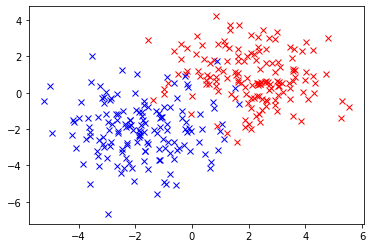

In [ ]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)
X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
C = 5
svm = SVM_no_intercept(X, y, C)

## QP solver to find true objective and minimum

### Definition of the solver

As in lab 3, we will use a method (here in the project a redefinition of the qp function defined earlier) to get a "precise" minimum to compare the different methods implemented. We will for that adapt the solver to our adapted dual problem (no constraint implicating A or b compared to the definition in Part 1). Thus we propose a function solving a quadratic problem of the form : 
$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; 0 \leq x \leq C.
  \end{array}
  \right.
$$ 

*Method*: We will compute the true value using this solver and then use it and the loss obtained with this value, to calculate with each algorithm, the error between values and objectives distance. 

In [ ]:
import cvxopt

def qp_solver_p(H, e, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    e = cvxopt.matrix(-e)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

### Find the minimizing point and the minimum of the objective

In [ ]:
mu_min = qp_solver_p(svm.H, svm.e, C, l=1e-8, verbose=False)
loss_min = svm.loss(mu_min)
print("loss_min :",loss_min)

loss_min : -181.27495618994746


## Other functions

### Define a function to monitor operations (Lab 2)

In [ ]:
from scipy.linalg import norm
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        x, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]
        self.x = x

### Define plotting functions (Lab 2)

In [ ]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("$loss(\mu_k)-loss_{min}(\mu_{QP}))$")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|\mu_k - \mu^{QP}\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$loss(\mu_k)-loss_{min}(\mu_{QP}))$")

    plt.legend(solvers)

## Proximal Gradient Descent without acceleration (Iterative Soft Thresholding Algorithm - ISTA)

In [ ]:
def pgd(x_init, grad, prox, n_iter=100, step=1.,args=(), store_every=1):
    """Proximal Gradient Method without acceleration algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        x = prox(x - step * grad(x))   
        # Update metrics after each iteration.
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
%%time
from time import time
step = 1. / svm.lipschitz_cst()
n_iter=50000
mu0 = np.zeros(svm.n)
monitor_pgd = monitor(pgd, svm.loss, mu_min, ())
monitor_pgd.run(mu0, svm.grad_f,svm.prox_g, n_iter, step, args=())

CPU times: user 6.95 s, sys: 3.76 s, total: 10.7 s
Wall time: 5.57 s


## Proximal Gradient Descent with acceleration (Fast ISTA - FISTA)

In [ ]:
def apgd(x_init, grad, prox, n_iter=100, step=1.,args=(), store_every=1):
    """Proximal gradient algorithm with acceleration algorithm."""
    x = x_init.copy()
    x_list = []
    y = x_init.copy() 
    t = 1.

    for i in range(n_iter):
        x_new = prox(y - step * grad(x))
        t_new = (1. + np.sqrt(1 + 4 * t * t)) / 2
        y = x_new + (t - 1) / t_new * (x_new - x)
        x = x_new
        t = t_new
    
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
%%time
step = 1. / svm.lipschitz_cst()
n_iter=50000
mu0 = np.zeros(svm.n)
monitor_apgd = monitor(apgd, svm.loss, mu_min, ())
monitor_apgd.run(mu0, svm.grad_f,svm.prox_g, n_iter, step, args=())

CPU times: user 7.53 s, sys: 4.51 s, total: 12 s
Wall time: 6.26 s


### Plot comparison

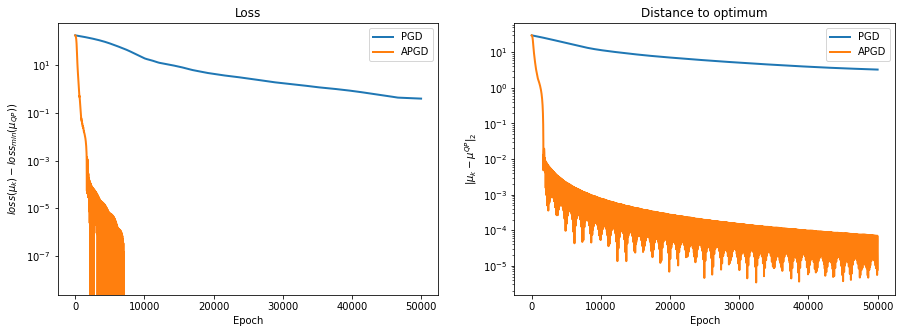

In [ ]:
monitors = [monitor_pgd, monitor_apgd]

solvers = ["PGD", "APGD"]

plot_epochs(monitors, solvers)

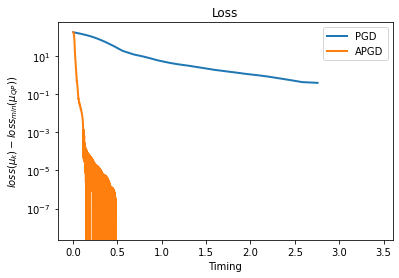

In [ ]:
plot_time(monitors, solvers)

#### Comments
We can note that both proximal gradient with and without acceleration have expected behaviour. 

*   The proximal gradient algorithm without acceleration has a linear convergence with rate $O(1/k)$ seen in class. 
*   The proximal gradient algorithm with acceleration is faster with a convergence rate of $O(1/k^2)$. It is not a descent algorithm
*   Cost of iteration for both is of $O(nd)$
*   We also notice when comparing the support vectors that the ones we get using FISTA algorithm are closer than the ones found by the QP solver than the ones we get using the ISTA which is explained by the faster convergence of the FISTA. 








## Coordinate Descent 

### Simple Coordinate descent

In [ ]:
def cd(x_init, n, grad, prox, n_iter=100, step=1., args=(), store_every=1):
    x = x_init.copy()
    x_list = []
    for k in range(n_iter):
        i = k % n
        x[i] = prox(x[i] - step[i] * grad(x, i))
 
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
%%time
step = 1. / svm.lipschitz_cst_i()
n_iter=50000
mu0 = np.zeros(svm.n)
monitor_cd = monitor(cd, svm.loss, mu_min, args=())
monitor_cd.run(mu0, svm.n, svm.grad_j,svm.prox_g, n_iter, step, args=())

CPU times: user 4.08 s, sys: 2.02 s, total: 6.1 s
Wall time: 3.53 s


### Smart updates Coordinate descent

The coordinate descent algorithm is a product of two vectors of size $n$ which is $O(n)$.

But in the linear SVM case: 
$$
\nabla_i f(\mu) =  \sum_{i=1}^n y_i w^T x_i -1
$$

We for that, need to update $w$ thus we can use : 
$$
w_{k+1} = w_{k} + (\mu_{k+1} ^{(i)} - \mu_{k} ^{(i)}) y_i x_i
$$
which is only $O(d)$.

In [ ]:
def smart_cd(x_init, n, grad, get_w, update_w, H, prox, n_iter=100, step=1., args=(), store_every=1):
    x = x_init.copy()
    x_list = []
    w = get_w(x)
    for k in range(n_iter):
        i = k % n
        xi_old = x[i]
        grad_i = grad(w, i)
        x[i] = prox(x[i] - step[i] * grad_i)
        w = update_w(xi_old, x[i], w, i)
        
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
%%time
step = 1. / svm.lipschitz_cst_i()
n_iter=50000
mu0 = np.zeros(svm.n)
monitor_scd = monitor(smart_cd, svm.loss, mu_min, args=())
monitor_scd.run(mu0, svm.n, svm.grad_j_cd, svm.get_w, svm.update_w, svm.H, svm.prox_g, n_iter, step, args=())

CPU times: user 4.2 s, sys: 2 s, total: 6.2 s
Wall time: 3.69 s


### Comparisons

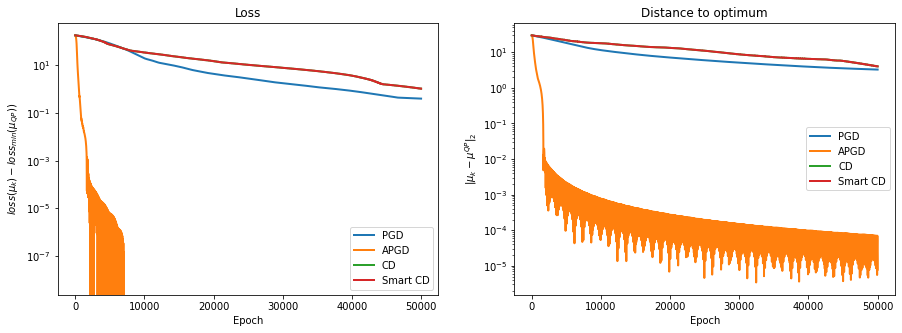

In [ ]:
monitors = [monitor_pgd, monitor_apgd, monitor_cd, monitor_scd]

solvers = ["PGD", "APGD", "CD", "Smart CD"]

plot_epochs(monitors, solvers)

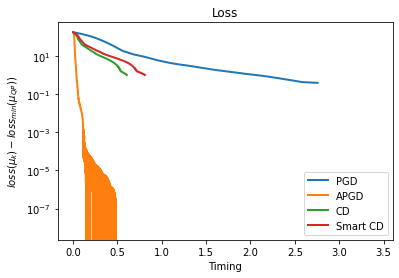

In [ ]:
plot_time(monitors, solvers)

## LBFGS-B

In [ ]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [ ]:
%%time
from scipy.optimize import fmin_l_bfgs_b
bounds = [(0, C) for i in range(svm.n)]
mu0 = np.zeros(svm.n)
monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), svm.loss, mu_min, ())
monitor_bfgs.run(svm.loss, mu0, svm.grad_f, maxiter=50000, factr=10,bounds=bounds, args=())

CPU times: user 151 ms, sys: 62.1 ms, total: 214 ms
Wall time: 137 ms


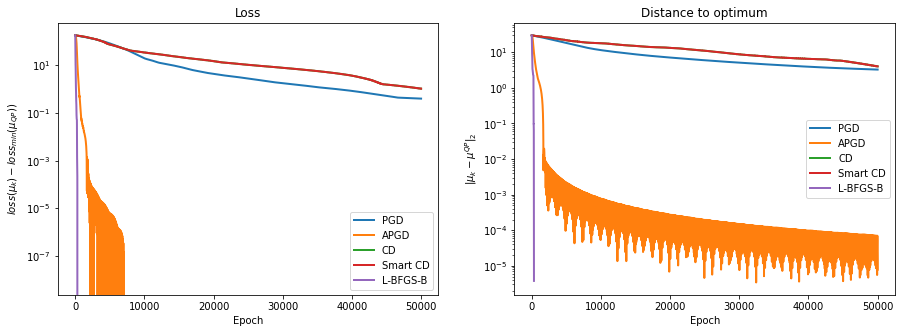

In [ ]:
monitors = [monitor_pgd, monitor_apgd, monitor_cd,monitor_scd, monitor_bfgs]

solvers = ["PGD", "APGD", "CD","Smart CD", "L-BFGS-B"]

plot_epochs(monitors, solvers)

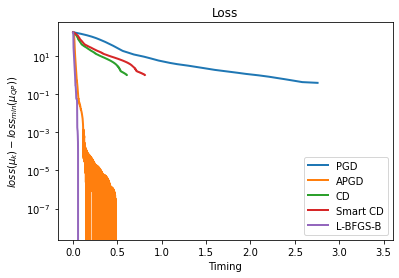

In [ ]:
plot_time(monitors, solvers)

In [ ]:
print(len(monitor_apgd.obj))
print(len(monitor_pgd.obj))
print(len(monitor_cd.obj))
print(len(monitor_bfgs.obj))

50000
50000
50000
321


## Comments 


*   We can see that the coorddinate descent algorithm converges quicker than ISTA or FISTA. Indeed, it means that we require less evaluations than those algorithms to converge. Indeed, we have $L_i<L(\nabla f)$. Nevertheless, this method is more costly as the previous ones as the cost is of $O(n^2)$ (cycle over all coordinates of the gradient with $O(n)$ as cost for each iteration). 
*   We can also notice that LBFGS converges very quickly
*   We also noticce that BFGSB requires the less computational time from far. 





<div class="alert alert-info">
    <h2>Part 5: SVM Rank</h2>
</div>

You will now use the code you have written above to answer the following question: given two samples $x_i$ and $x_j$ in $\mathbb{R}^p$, with corresping labels $y_i$ and $y_j$ in $\mathbb{R}$ (note that now labels can be any real number, it's not just binary). Can I predict if $y_i > y_j$ or the oppositve?

To take a concrete example, imaging you go to a liquor store to buy a bottle on wine and you hesitate between two bottles. The SVM Rank model below will tell you if the quality of the wine encoded in the target $y$ is better for the first bottle or the second one.

Let's formalize this a bit. We aim to estimate a linear function $f_{w}(x) = x^\top w$ that minimizes
the following risk:

$$
\mathcal{R}_f=\mathbb{E}
    \left[
    \ell(f_w(x_i) - f_w(x_j), \mathrm{sign}(y_i-y_j))
    \right]
$$

where the loss $\ell$ is the Hinge loss of the SVM binary classifical model you have seen above. Namely:
$
    \ell(z, t) = \max(1 - tz, 0)
$ . Note that we limit ourselves here to linear SVM.

This leads to the following regularized empirical risk minimization problem:

$$
\hat{w} = \mathrm{arg}\,\min_{w \in \mathbb{R}^p} \left( C \sum_{i,j} \ell((x_i - x_j)^\top w, \mathrm{sign}(y_i-y_j)) + \|w\|_2^2 \right),
$$


This part is inspired by the following works:

    - R. Herbrich, T. Graepel, and K. Obermayer. Large margin rank boundaries for ordinal regression. MIT Press, Cambridge, MA, 2000.

    - T. Joachims. Optimizing search engines using clickthrough data. In Proceedings of the eighth ACM SIGKDD international conference on Knowledge discovery and data mining, pages 133–142, New York, NY, USA, 2002. ACM. 2
    
The following cell implements the `transform_pairwise` function. Given `X` and `y` this function builds all the pairs of samples to output a new dataset that corresponds to a binary classification problem. It basically outputs the differences between feature vectors and the sign of the difference of the targets.

In [ ]:
import itertools


def transform_pairwise(X, y):
    """Transforms data into pairs with balanced labels for ranking

    Transforms a n-class ranking problem into a two-class classification
    problem.

    In this method, all pairs are choosen, except for those that have the
    same target value. The output is an array of balanced classes, i.e.
    there are the same number of -1 as +1

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        Target labels.

    Returns
    -------
    X_trans : array, shape (n_pairs, n_features)
        Data formed by difference of feature vectors.
    y_trans : array, shape (n_pairs,)
        Output class labels, where classes have values {-1, +1}
    """
    X_new = []
    y_new = []
    comb = itertools.combinations(range(X.shape[0]), 2)
    k = 0
    for (i, j) in comb:
        if y[i] == y[j]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i] - y[j]))
        # output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
        k += 1
    return np.array(X_new), np.array(y_new)

<div class="alert alert-success">
    <b>QUESTION 17:</b>
     The following cell implements a scikit-learn estimator for the SVM Rank
     model. It uses the liblinear solver shipped with scikit-learn.
     <ul>
       <li>Update the following code to use a solver developed above instead of scikit-learn LinearSVC estimator.
         You will justify this choice of solver in terms of performance
         based your experiments above.</li>
       <li>Run your updated estimator on the Wine quality dataset
         and compare the performance of your model with the liblinear
         solver. You will compare in terms of prediction score
         and in terms of computation time.</li>
    </ul>
</div>

**Note:** For the scorer we use here the [Kendall's rank correlation](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient)

$$
    \tau ={\frac {2}{n(n-1)}}\sum _{i<j}\operatorname {sgn}(x_{i}-x_{j})\operatorname {sgn}(y_{i}-y_{j})
$$

implemented in `scipy.stats.kendalltau`.

In [ ]:
from scipy import stats
from sklearn import svm
from sklearn.base import BaseEstimator, RegressorMixin


class RankSVM(BaseEstimator, RegressorMixin):
    """Performs pairwise ranking with an underlying linear SVM model

    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    """
    def __init__(self, C=1.0):
        self.C = C

    def fit(self, X, y):
        """Fit a pairwise ranking model.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        self
        """
        self.svc_ = svm.LinearSVC(loss='hinge', dual=True, tol=1e-2,
            fit_intercept=True, C=self.C, max_iter=1000000)
        X_trans, y_trans = transform_pairwise(X, y)
        self.svc_.fit(X_trans, y_trans)
        return self

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)

        Returns
        -------
        ord : array, shape (n_samples,)
            Returns an array of integers representing the relative order of
            the rows in X.
        """
        return np.argsort(np.dot(X, self.svc_.coef_.T).ravel())

    def score(self, X, y):
        """Score using Kendall rank correlation
        
        https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        score : float
            Kendall Tau rank correlation. Higher is better.
        """
        return stats.kendalltau(self.predict(X), y)[0]

In [ ]:
# Loading the data
import pandas as pd
from sklearn.model_selection import cross_val_score

df = pd.read_csv('winequality-red.csv', delimiter=';')
df.head()

FileNotFoundError: ignored

In [ ]:
%%time

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

df_small = df[::2]  # take a smaller dataset to speed things up
X = df_small.iloc[:, :-1].values

y = df_small.quality.values
clf = make_pipeline(StandardScaler(), RankSVM(C=1.))
scores = cross_val_score(clf, X, y, cv=3)
print("Average Kendall Rank Correlation: %0.2f" % scores.mean())